The “Food 101” dataset was chosen from TensorFlow datasets, from https://www.tensorflow.org/datasets/catalog/food101. This dataset consists of 101 food categories, with a total of 101,000 images, 1000 images for each food category. For each class, there are 750 training images and 250 test images. The dataset came with unpolished examples, including heterogenous image sizes, some image noise, and occasionally incorrect labels.

Here, a model was trained for classifying these food images into their respective categories. We did this by building classification and embedding models. The data was preprocessed by setting all the images into the same size and converting the datatype from `uint8` to `float32`. A model was trained to classify the images. It would be also be interesting to cluster these images, so the second-to-last layer of the model was used for embedding.

## Import TensorFlow Food101 Dataset

Link to Dataset: https://www.tensorflow.org/datasets/catalog/food101

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

First, load the dataset using `tfds.load` by passing in a few parameters: 


*   `name`: the target dataset we are using
*   `split`: splits and trains the data into training data and test data
*   `shuffle_files`: shuffles the dataset once downloaded
*   `as_supervised`: `True` to download data samples in tuple format (`(data, label)`)




In [ ]:
# Load the dataset
(raw_train_data, raw_test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

## Visualize the Data

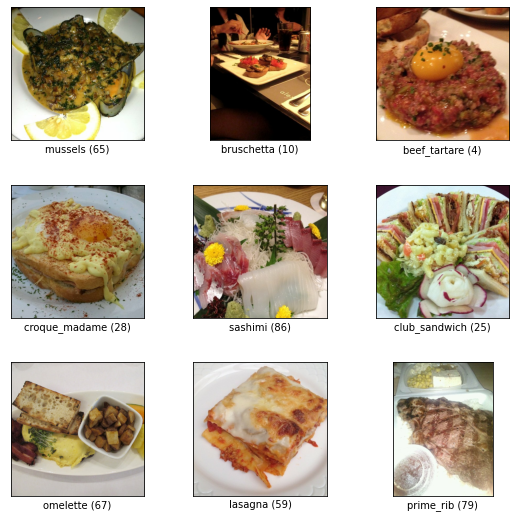

In [ ]:
# Look at examples of Food101 images
fig = tfds.show_examples(raw_train_data, ds_info)

In [ ]:
# Get class names
class_names = ds_info.features["label"].names
for i, name in enumerate(class_names):
    print(i, name)

0 apple_pie
1 baby_back_ribs
2 baklava
3 beef_carpaccio
4 beef_tartare
5 beet_salad
6 beignets
7 bibimbap
8 bread_pudding
9 breakfast_burrito
10 bruschetta
11 caesar_salad
12 cannoli
13 caprese_salad
14 carrot_cake
15 ceviche
16 cheesecake
17 cheese_plate
18 chicken_curry
19 chicken_quesadilla
20 chicken_wings
21 chocolate_cake
22 chocolate_mousse
23 churros
24 clam_chowder
25 club_sandwich
26 crab_cakes
27 creme_brulee
28 croque_madame
29 cup_cakes
30 deviled_eggs
31 donuts
32 dumplings
33 edamame
34 eggs_benedict
35 escargots
36 falafel
37 filet_mignon
38 fish_and_chips
39 foie_gras
40 french_fries
41 french_onion_soup
42 french_toast
43 fried_calamari
44 fried_rice
45 frozen_yogurt
46 garlic_bread
47 gnocchi
48 greek_salad
49 grilled_cheese_sandwich
50 grilled_salmon
51 guacamole
52 gyoza
53 hamburger
54 hot_and_sour_soup
55 hot_dog
56 huevos_rancheros
57 hummus
58 ice_cream
59 lasagna
60 lobster_bisque
61 lobster_roll_sandwich
62 macaroni_and_cheese
63 macarons
64 miso_soup
65 muss

## Explore Data 

To explore and understand our data further, we will look at a few details about our dataset:
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names?

First, let's take one sample off the training data and look at it. 

In [ ]:
# Take one sample off the training data and explore what it looks like
train_one_sample = raw_train_data.take(1) # samples are in format (image_tensor, label)

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 77
  Class name (str form): pork_chop
        


Since we used shuffling, every time we run this, we will get a different result. We noticed that some of the images have different shapes. For example `(512, 342, 3)` and `(512, 512, 3)` (height, width, color_channels).

This shows that the images in the dataset have different sizes. We will need to preprocess the data to ensure that all the images are of the same size. 

## Plot an Image

Plot one of the image samples using `matplotlib.pyplot.imshow()` and then set the title to target class name.

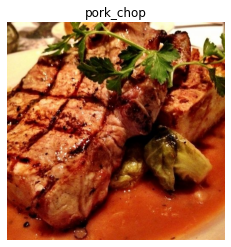

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

## Preprocessing the Data

We have to do some preprocessing steps before we pass the data through the model. 

*   The data is currently in `uint8` format. 
*   Values of image tensors are between 0 and 255 (standard color values)
*   The images are all of different sizes. 

To preprocess the data, we will convert the data through the following:    
*   Convert the datatype to `float32` format. 
*   Scale the values by dividing by 255 (for matplotlib capability). 
*   Normalize the image sizes by setting them all into the same size. 



In [ ]:
# This function will convert the images from dtype uint-8 to float32
# This function will also change all the different image sizes to the same size
IMAGE_DIM = 224

def image_processing(image, label, img_shape=IMAGE_DIM):
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32) , label # return (float32_image, label) tuple


## Prepare dataset

In [ ]:
BATCH_SIZE = 32
# Map preprocessing function to training data (and parallelize)
train_data = raw_train_data.map(map_func=image_processing, num_parallel_calls=tf.data.AUTOTUNE).take(100000)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = raw_test_data.map(image_processing, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

## Build the Model

In [ ]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

In [ ]:
# Build classification and embedding models
output_size = 101
embedding_size = 100
DROPOUT_FRAC = 0.2

inputs = tf.keras.layers.Input(shape=(IMAGE_DIM, IMAGE_DIM, 3))
x = base_model(inputs, training = False)
x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D(name='poolingLayer')(x)

# x = tf.keras.layers.Dense(128, activation='relu')(x)
# x = tf.keras.layers.Dense(128, activation='relu')(x)
embedding = tf.keras.layers.Dense(embedding_size, activation='relu')(x)
outputs = tf.keras.layers.Dense(output_size, activation='softmax')(embedding)

# This model classifies images of food
model = tf.keras.Model(inputs, outputs)

# This model embeds images of food so that we can cluster them.
# The embedding model is a subset of the classification model, so by training
# the classification model, we get the embedding model for free.
embedding_model = tf.keras.Model(inputs, embedding)

model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 32)          368672    
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 32)          9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                                 
 poolingLayer (GlobalAverage  (None, 32)               0         
 Pooling2D)                                                

In [ ]:
# Compile the model (this will reset any training)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[
             tf.keras.metrics.SparseCategoricalAccuracy(),
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 5)
             ],
)

In [ ]:
# Train the model
model.fit(
    train_data,
    epochs=6,
    validation_data=test_data,
)

Epoch 1/6
2368/2368 [==============================] - 472s 195ms/step - loss: 2.3562 - sparse_categorical_accuracy: 0.4116 - sparse_top_k_categorical_accuracy: 0.6924 - val_loss: 1.7365 - val_sparse_categorical_accuracy: 0.5427 - val_sparse_top_k_categorical_accuracy: 0.8168
Epoch 2/6
2368/2368 [==============================] - 463s 195ms/step - loss: 1.7701 - sparse_categorical_accuracy: 0.5399 - sparse_top_k_categorical_accuracy: 0.8063 - val_loss: 1.6454 - val_sparse_categorical_accuracy: 0.5615 - val_sparse_top_k_categorical_accuracy: 0.8308
Epoch 3/6
2368/2368 [==============================] - 417s 175ms/step - loss: 1.5590 - sparse_categorical_accuracy: 0.5884 - sparse_top_k_categorical_accuracy: 0.8405 - val_loss: 1.5600 - val_sparse_categorical_accuracy: 0.5884 - val_sparse_top_k_categorical_accuracy: 0.8429
Epoch 4/6
2368/2368 [==============================] - 463s 195ms/step - loss: 1.4047 - sparse_categorical_accuracy: 0.6209 - sparse_top_k_categorical_accuracy: 0.8644 -

In [ ]:
model.evaluate(test_data)

790/790 [==============================] - 99s 126ms/step - loss: 1.6489 - sparse_categorical_accuracy: 0.5891 - sparse_top_k_categorical_accuracy: 0.8408


[1.6489136219024658, 0.5891485214233398, 0.8407524824142456]

In [ ]:
# Show embedding for a few classes

# 58 ice_cream
# 62 macaroni_and_cheese
# 75 pho
# 76 pizza
# 96 tacos

# Grab examples from the test set for specific classes
unbatched = test_data.unbatch().filter(lambda image, label: (
    False
    #or label == 58
    #or label == 62
    #or label == 75
    or label == 76
    or label == 96
    )
)
X = unbatched.batch(32)
colors = np.asarray(list(tfds.as_numpy(unbatched.map(lambda image, label: label))))

# Run those examples through the model to get their embeddings
embeddings = embedding_model.predict(X, verbose=1)

16/16 [==============================] - 46s 3s/step


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


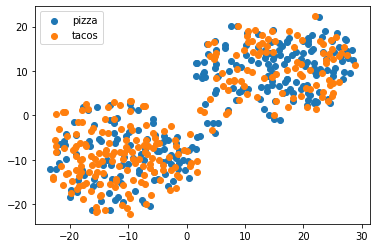

In [ ]:
# Use TSNE to visualize the clusters
from sklearn.manifold import *
from sklearn.decomposition import PCA
from functools import partial

n_neighbors = 10
n_components = 2

LLE = partial(
    LocallyLinearEmbedding,
    n_neighbors=n_neighbors,
    n_components=n_components,
    eigen_solver="auto",
)

Y = TSNE().fit_transform(embeddings)
#Y = PCA(n_components=2, svd_solver='full').fit_transform(embeddings)
#Y = LLE(method="standard").fit_transform(embeddings)

color_map = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
# Plot results
f, ax = plt.subplots()
for i, label in enumerate([76,96]):
    data = Y[colors == label, :]
    ax.scatter(data[:,0], data[:,1], c=color_map[i], label=class_names[label], cmap=plt.cm.Spectral)
ax.axis("tight")
ax.legend()

plt.show()

# Conclusion
To summarize, a model was trained for classifying food images into their respective categories. The data was preprocessed by scaling all the images into the same size and datatype. Then, a model was built by transfer-learning from a pre-trained model, EfficientNetB0. Classification accuracy was reported, and experiments with clustering based on internal network layers were also conducted.

As the number of dense layers increased and the pooling layers were changed, the classification accuracy remained relatively similar. This could be due to the intentionally unclean nature of the dataset. It is also possible that some categories of food are difficult to distinguish from each other. For example, the model may be having trouble distinguishing between clam chowder and French onion soup.

The T-SNE plot visually showed that it even at the second-to-last layer, the classes were not easily separated.
